Minutely Model

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load the cleaned dataset (Timestamp is already the index)
df = pd.read_csv("btc_last_45_days_minutely.csv", index_col=0, parse_dates=True)

# Quick preview
print("Data loaded successfully!")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head()

Data loaded successfully!
Rows: 64,800 | Columns: 5


,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-03-12 03:21:00,81585.72,81630.01,81561.12,81561.12,53.70359
2025-03-12 03:22:00,81561.12,81591.37,81523.10,81580.69,11.89619
2025-03-12 03:23:00,81580.69,81586.88,81519.80,81573.31,7.24745
2025-03-12 03:24:00,81573.30,81573.31,81531.55,81547.33,5.72584
2025-03-12 03:25:00,81547.33,81579.02,81516.36,81528.79,6.75805


2. Exploratory Data Analysis
- 2.1. Dataset Summary

In [ ]:
# Basic info
#Only keep last 45 days
df = df.last("45D")
print("Date Range:")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")

print("\nColumns:")
print(df.columns.tolist())

print("\nMissing values per column:")
print(df.isna().sum())

Date Range:
Start: 2025-03-12 03:21:00
End:   2025-04-26 03:20:00

Columns:
['Open', 'High', 'Low', 'Close', 'Volume']

Missing values per column:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


<ipython-input-3-9ccbcdf64831>:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df = df.last("45D")


3: Feature Engineering and Informer Sequence Preparation

This section derives key technical indicators to enhance the model's predictive ability by capturing market patterns and dynamics:

- **Log Returns**  
  Computed as the natural logarithm of consecutive closing prices. This stabilizes variance and better models relative price changes.

- **Moving Averages (MA)**  
  - `MA_20`: 20-period simple moving average to capture short-term trends.  
  - `MA_50`: 50-period simple moving average for medium-term trends.

- **Exponential Moving Average (EMA)**  
  - `EMA_20`: Weighted average that reacts more significantly to recent price changes.

- **Bollinger Bands**  
  Defined as:
  - Upper Band = `MA_20` + 2 × rolling standard deviation  
  - Lower Band = `MA_20` - 2 × rolling standard deviation  
  Helps identify periods of high or low volatility.

- **Relative Strength Index (RSI)**  
  Measures the strength and speed of price movements over a 14-period window. Values above 70 indicate overbought conditions, while below 30 indicate oversold.

- **Rolling Volatility**  
  Calculated as the standard deviation of log returns over a 60-period window, indicating how much the price fluctuates over time.

Finally, we drop any rows with `NaN` values that result from rolling calculations to ensure data consistency.


In [ ]:
# Feature Engineering
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
rolling_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['MA_20'] + 2 * rolling_std
df['BB_lower'] = df['MA_20'] - 2 * rolling_std

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Volatility (rolling std of log returns)
df['Volatility'] = df['Log_Returns'].rolling(window=60).std()

# Lag features
df['Close_lag_1'] = df['Close'].shift(1)
df['Close_lag_2'] = df['Close'].shift(2)

# Directional target (1 = up, 0 = down)
df['Direction'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaNs from rolling/lags
df.dropna(inplace=True)

# Preview
df[['Close', 'Log_Returns', 'RSI', 'Volatility', 'Direction']].head()

,Close,Log_Returns,RSI,Volatility,Direction
Timestamp,,,,,
2025-03-12 04:21:00,82482.27,0.000533,49.249958,0.001170,0
2025-03-12 04:22:00,82306.63,-0.002132,39.075060,0.001207,0
2025-03-12 04:23:00,82118.14,-0.002293,34.915405,0.001247,1
2025-03-12 04:24:00,82204.00,0.001045,38.563932,0.001252,1
2025-03-12 04:25:00,82342.91,0.001688,42.808834,0.001267,1


- 3.2. Feature Selection

In [ ]:
features = [
    'Close', 'Volume', 'MA_20', 'MA_50', 'EMA_20',
    'BB_upper', 'BB_lower', 'RSI', 'Volatility',
    'Close_lag_1', 'Close_lag_2'
]

target_cols = ['Close', 'Volatility', 'Direction']

- 3.3. Scaling
  
  We will normalize features and targets using MinMaxScaler.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale inputs
feature_scaler = MinMaxScaler()
X_scaled_h = feature_scaler.fit_transform(df[features])

# Scale targets
target_scaler = MinMaxScaler()
y_scaled_h = target_scaler.fit_transform(df[target_cols])

PyTorch-Style Dataset That Reads From X_scaled Directly

In [ ]:
from torch.utils.data import Dataset

class BitcoinMultiTaskDataset(Dataset):
    def __init__(self, X_scaled, df_targets, window_size):
        self.X = X_scaled
        self.close = df_targets['Close'].values
        self.volatility = df_targets['Volatility'].values
        self.direction = df_targets['Direction'].values
        self.window_size = window_size

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.window_size]
        y_close = self.close[idx + self.window_size]
        y_vol = self.volatility[idx + self.window_size]
        y_dir = self.direction[idx + self.window_size]
        return (
            torch.tensor(x_seq, dtype=torch.float32),
            torch.tensor([y_close, y_vol, y_dir], dtype=torch.float32)
        )

Split Chronologically

In [ ]:
from torch.utils.data import DataLoader, random_split

# Set window size
window_size = 60

# Build dataset
multi_dataset = BitcoinMultiTaskDataset(X_scaled_h, df[['Close', 'Volatility', 'Direction']], window_size=window_size)

# Train/Test split (80/20)
train_size = int(len(multi_dataset) * 0.8)
test_size = len(multi_dataset) - train_size

train_dataset, test_dataset = random_split(multi_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train Samples: {len(train_dataset)} | Test Samples: {len(test_dataset)}")

Train Samples: 51744 | Test Samples: 12936


# Daily Transformer model to forecast Minute-wise BTC price and volatility.

Define Time Series Transformer

In [ ]:
import torch.nn as nn

class MultiTaskTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(MultiTaskTransformer, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output: [Close, Volatility, Direction]
        self.output_layer = nn.Linear(d_model, 3)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_layer(x[:, -1, :])  # Use last time step's output

### Define Mixed Loss Function for Multi-Task Output
Since we’re predicting 3 outputs:

- Close (regression)

- Volatility (regression)

- Direction (binary classification)

We'll use a composite loss combining:

- SmoothL1Loss for Close & Volatility

- BCEWithLogitsLoss for Direction (no sigmoid needed in model)

In [ ]:
# Define loss functions
regression_loss = nn.SmoothL1Loss()
classification_loss = nn.BCEWithLogitsLoss()

def multi_task_loss(preds, targets, alpha=10):
    """
    preds: tensor of shape (batch_size, 3)
    targets: tensor of shape (batch_size, 3)
    alpha: weight for classification loss
    """
    pred_close = preds[:, 0]
    pred_vol = preds[:, 1]
    pred_dir = preds[:, 2]

    target_close = targets[:, 0]
    target_vol = targets[:, 1]
    target_dir = targets[:, 2]

    loss_close = regression_loss(pred_close, target_close)
    loss_vol = regression_loss(pred_vol, target_vol)
    loss_direction = classification_loss(pred_dir, target_dir)

    return loss_close + loss_vol + alpha * loss_direction

Train Daily Transformer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model = MultiTaskTransformer(input_size=X_scaled_h.shape[1]).to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# Confirm model structure
print(model)

MultiTaskTransformer(
  (input_proj): Linear(in_features=11, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
from tqdm.notebook import tqdm

epochs = 200
model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X)

        loss = multi_task_loss(preds, batch_y, alpha=1.0)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} — Avg Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 1 — Avg Loss: 84609.1929


Epoch 2/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 2 — Avg Loss: 84495.9858


Epoch 3/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 3 — Avg Loss: 84306.2336


Epoch 4/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 4 — Avg Loss: 84054.1230


Epoch 5/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 5 — Avg Loss: 83747.6916


Epoch 6/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 6 — Avg Loss: 83392.9810


Epoch 7/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 7 — Avg Loss: 82993.2653


Epoch 8/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 8 — Avg Loss: 82550.5786


Epoch 9/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 9 — Avg Loss: 82068.1020


Epoch 10/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 10 — Avg Loss: 81545.1632


Epoch 11/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 11 — Avg Loss: 80983.0784


Epoch 12/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 12 — Avg Loss: 80383.3283


Epoch 13/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 13 — Avg Loss: 79746.5986


Epoch 14/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 14 — Avg Loss: 79073.0584


Epoch 15/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 15 — Avg Loss: 78363.0649


Epoch 16/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 16 — Avg Loss: 77618.2167


Epoch 17/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 17 — Avg Loss: 76838.0930


Epoch 18/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 18 — Avg Loss: 76024.8399


Epoch 19/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 19 — Avg Loss: 75177.1584


Epoch 20/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 20 — Avg Loss: 74296.1701


Epoch 21/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 21 — Avg Loss: 73382.9574


Epoch 22/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 22 — Avg Loss: 72437.5085


Epoch 23/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 23 — Avg Loss: 71462.0187


Epoch 24/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 24 — Avg Loss: 70453.0153


Epoch 25/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 25 — Avg Loss: 69415.5837


Epoch 26/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 26 — Avg Loss: 68347.0672


Epoch 27/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 27 — Avg Loss: 67248.4168


Epoch 28/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 28 — Avg Loss: 66121.3518


Epoch 29/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 29 — Avg Loss: 64964.5446


Epoch 30/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 30 — Avg Loss: 63780.7460


Epoch 31/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 31 — Avg Loss: 62568.3742


Epoch 32/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 32 — Avg Loss: 61329.0280


Epoch 33/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 33 — Avg Loss: 60061.8739


Epoch 34/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 34 — Avg Loss: 58768.4694


Epoch 35/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 35 — Avg Loss: 57449.2470


Epoch 36/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 36 — Avg Loss: 56103.0312


Epoch 37/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 37 — Avg Loss: 54733.1076


Epoch 38/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 38 — Avg Loss: 53336.1362


Epoch 39/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 39 — Avg Loss: 51914.5587


Epoch 40/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 40 — Avg Loss: 50471.0516


Epoch 41/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 41 — Avg Loss: 49002.5866


Epoch 42/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 42 — Avg Loss: 47508.8222


Epoch 43/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 43 — Avg Loss: 45991.5956


Epoch 44/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 44 — Avg Loss: 44453.3095


Epoch 45/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 45 — Avg Loss: 42893.2487


Epoch 46/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 46 — Avg Loss: 41310.7064


Epoch 47/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 47 — Avg Loss: 39706.3843


Epoch 48/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 48 — Avg Loss: 38079.1676


Epoch 49/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 49 — Avg Loss: 36429.7206


Epoch 50/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 50 — Avg Loss: 34758.7620


Epoch 51/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 51 — Avg Loss: 33069.3148


Epoch 52/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 52 — Avg Loss: 31359.6924


Epoch 53/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 53 — Avg Loss: 29632.9480


Epoch 54/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 54 — Avg Loss: 27885.4408


Epoch 55/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 55 — Avg Loss: 26118.5250


Epoch 56/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 56 — Avg Loss: 24331.2963


Epoch 57/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 57 — Avg Loss: 22524.6206


Epoch 58/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 58 — Avg Loss: 20699.9961


Epoch 59/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 59 — Avg Loss: 18854.9918


Epoch 60/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 60 — Avg Loss: 16991.7707


Epoch 61/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 61 — Avg Loss: 15111.8096


Epoch 62/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 62 — Avg Loss: 13217.4621


Epoch 63/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 63 — Avg Loss: 11306.3423


Epoch 64/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 64 — Avg Loss: 9383.9509


Epoch 65/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 65 — Avg Loss: 7512.0490


Epoch 66/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 66 — Avg Loss: 5739.3904


Epoch 67/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 67 — Avg Loss: 3965.2650


Epoch 68/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 68 — Avg Loss: 2439.6647


Epoch 69/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 69 — Avg Loss: 1555.0501


Epoch 70/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 70 — Avg Loss: 1210.3954


Epoch 71/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 71 — Avg Loss: 1041.9844


Epoch 72/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 72 — Avg Loss: 910.7232


Epoch 73/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 73 — Avg Loss: 789.0126


Epoch 74/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 74 — Avg Loss: 692.7025


Epoch 75/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 75 — Avg Loss: 639.2996


Epoch 76/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 76 — Avg Loss: 611.4430


Epoch 77/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 77 — Avg Loss: 587.9409


Epoch 78/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 78 — Avg Loss: 570.3552


Epoch 79/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 79 — Avg Loss: 554.3379


Epoch 80/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 80 — Avg Loss: 541.1704


Epoch 81/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 81 — Avg Loss: 527.2131


Epoch 82/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 82 — Avg Loss: 515.5680


Epoch 83/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 83 — Avg Loss: 505.9155


Epoch 84/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 84 — Avg Loss: 499.6559


Epoch 85/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 85 — Avg Loss: 491.5147


Epoch 86/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 86 — Avg Loss: 488.2240


Epoch 87/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 87 — Avg Loss: 482.5201


Epoch 88/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 88 — Avg Loss: 476.2810


Epoch 89/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 89 — Avg Loss: 471.2154


Epoch 90/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 90 — Avg Loss: 468.7012


Epoch 91/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 91 — Avg Loss: 467.0378


Epoch 92/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 92 — Avg Loss: 464.1881


Epoch 93/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 93 — Avg Loss: 461.8626


Epoch 94/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 94 — Avg Loss: 459.5996


Epoch 95/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 95 — Avg Loss: 455.8001


Epoch 96/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 96 — Avg Loss: 453.0520


Epoch 97/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 97 — Avg Loss: 450.6722


Epoch 98/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 98 — Avg Loss: 448.4374


Epoch 99/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 99 — Avg Loss: 445.9272


Epoch 100/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 100 — Avg Loss: 444.1220


Epoch 101/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 101 — Avg Loss: 442.3196


Epoch 102/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 102 — Avg Loss: 442.9387


Epoch 103/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 103 — Avg Loss: 443.1768


Epoch 104/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 104 — Avg Loss: 442.1673


Epoch 105/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 105 — Avg Loss: 441.5293


Epoch 106/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 106 — Avg Loss: 440.2338


Epoch 107/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 107 — Avg Loss: 441.1170


Epoch 108/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 108 — Avg Loss: 437.4209


Epoch 109/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 109 — Avg Loss: 436.8714


Epoch 110/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 110 — Avg Loss: 434.9326


Epoch 111/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 111 — Avg Loss: 431.6506


Epoch 112/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 112 — Avg Loss: 430.7256


Epoch 113/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 113 — Avg Loss: 428.6217


Epoch 114/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 114 — Avg Loss: 427.8051


Epoch 115/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 115 — Avg Loss: 425.9388


Epoch 116/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 116 — Avg Loss: 425.5897


Epoch 117/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 117 — Avg Loss: 423.1662


Epoch 118/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 118 — Avg Loss: 423.1361


Epoch 119/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 119 — Avg Loss: 421.6365


Epoch 120/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 120 — Avg Loss: 420.0710


Epoch 121/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 121 — Avg Loss: 418.4889


Epoch 122/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 122 — Avg Loss: 416.6002


Epoch 123/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 123 — Avg Loss: 413.9668


Epoch 124/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 124 — Avg Loss: 411.0490


Epoch 125/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 125 — Avg Loss: 409.0490


Epoch 126/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 126 — Avg Loss: 406.8110


Epoch 127/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 127 — Avg Loss: 405.2153


Epoch 128/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 128 — Avg Loss: 403.3187


Epoch 129/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 129 — Avg Loss: 401.0232


Epoch 130/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 130 — Avg Loss: 397.9164


Epoch 131/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 131 — Avg Loss: 399.2150


Epoch 132/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 132 — Avg Loss: 396.2965


Epoch 133/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 133 — Avg Loss: 396.3263


Epoch 134/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 134 — Avg Loss: 395.1700


Epoch 135/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 135 — Avg Loss: 395.2366


Epoch 136/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 136 — Avg Loss: 393.4562


Epoch 137/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 137 — Avg Loss: 393.3672


Epoch 138/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 138 — Avg Loss: 392.9214


Epoch 139/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 139 — Avg Loss: 391.0549


Epoch 140/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 140 — Avg Loss: 391.3225


Epoch 141/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 141 — Avg Loss: 389.4198


Epoch 142/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 142 — Avg Loss: 388.1410


Epoch 143/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 143 — Avg Loss: 387.2515


Epoch 144/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 144 — Avg Loss: 388.5943


Epoch 145/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 145 — Avg Loss: 386.0855


Epoch 146/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 146 — Avg Loss: 386.4860


Epoch 147/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 147 — Avg Loss: 385.5104


Epoch 148/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 148 — Avg Loss: 384.9723


Epoch 149/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 149 — Avg Loss: 384.6393


Epoch 150/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 150 — Avg Loss: 382.8436


Epoch 151/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 151 — Avg Loss: 383.9553


Epoch 152/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 152 — Avg Loss: 384.0450


Epoch 153/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 153 — Avg Loss: 382.9005


Epoch 154/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 154 — Avg Loss: 382.3482


Epoch 155/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 155 — Avg Loss: 381.6619


Epoch 156/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 156 — Avg Loss: 382.8399


Epoch 157/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 157 — Avg Loss: 385.2518


Epoch 158/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 158 — Avg Loss: 386.8107


Epoch 159/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 159 — Avg Loss: 388.7915


Epoch 160/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 160 — Avg Loss: 389.8191


Epoch 161/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 161 — Avg Loss: 393.5551


Epoch 162/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 162 — Avg Loss: 395.1349


Epoch 163/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 163 — Avg Loss: 396.0331


Epoch 164/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 164 — Avg Loss: 396.2874


Epoch 165/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 165 — Avg Loss: 396.4182


Epoch 166/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 166 — Avg Loss: 397.0885


Epoch 167/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 167 — Avg Loss: 396.3723


Epoch 168/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 168 — Avg Loss: 397.3698


Epoch 169/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 169 — Avg Loss: 398.6008


Epoch 170/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 170 — Avg Loss: 399.8483


Epoch 171/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 171 — Avg Loss: 403.5261


Epoch 172/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 172 — Avg Loss: 407.5003


Epoch 173/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 173 — Avg Loss: 409.5767


Epoch 174/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 174 — Avg Loss: 412.2576


Epoch 175/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 175 — Avg Loss: 413.1745


Epoch 176/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 176 — Avg Loss: 413.7943


Epoch 177/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 177 — Avg Loss: 414.4760


Epoch 178/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 178 — Avg Loss: 415.1129


Epoch 179/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 179 — Avg Loss: 416.9106


Epoch 180/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 180 — Avg Loss: 417.8705


Epoch 181/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 181 — Avg Loss: 419.4576


Epoch 182/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 182 — Avg Loss: 419.7482


Epoch 183/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 183 — Avg Loss: 420.7876


Epoch 184/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 184 — Avg Loss: 421.2374


Epoch 185/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 185 — Avg Loss: 421.5056


Epoch 186/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 186 — Avg Loss: 423.9754


Epoch 187/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 187 — Avg Loss: 423.9365


Epoch 188/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 188 — Avg Loss: 424.5376


Epoch 189/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 189 — Avg Loss: 426.4498


Epoch 190/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 190 — Avg Loss: 427.8789


Epoch 191/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 191 — Avg Loss: 430.0111


Epoch 192/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 192 — Avg Loss: 431.8835


Epoch 193/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 193 — Avg Loss: 432.4985


Epoch 194/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 194 — Avg Loss: 432.3750


Epoch 195/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 195 — Avg Loss: 432.6541


Epoch 196/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 196 — Avg Loss: 433.7946


Epoch 197/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 197 — Avg Loss: 435.1382


Epoch 198/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 198 — Avg Loss: 436.4012


Epoch 199/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 199 — Avg Loss: 439.6921


Epoch 200/200:   0%|          | 0/809 [00:00<?, ?it/s]

Epoch 200 — Avg Loss: 440.0170


Evaluation Block: Minutely Transformer

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
preds, actuals = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X).cpu().numpy()
        preds.append(outputs)
        actuals.append(batch_y.numpy())

# Stack predictions and targets
preds = np.vstack(preds)
actuals = np.vstack(actuals)

# Split predicted vs actual values
pred_return = preds[:, 0]
pred_vol     = preds[:, 1]
pred_dir_logit = preds[:, 2]
pred_dir = (torch.sigmoid(torch.tensor(pred_dir_logit)) > 0.5).int().numpy()

true_return = actuals[:, 0]
true_vol    = actuals[:, 1]
true_dir    = actuals[:, 2]

# --- Metrics ---
rmse_return = np.sqrt(mean_squared_error(true_return, pred_return))
mae_return  = mean_absolute_error(true_return, pred_return)

rmse_vol = np.sqrt(mean_squared_error(true_vol, pred_vol))
mae_vol  = mean_absolute_error(true_vol, pred_vol)

directional_acc = (pred_dir == true_dir).sum() / len(true_dir) * 100

# --- Display ---
print(f"Log Return RMSE: {rmse_return:.6f}")
print(f"Log Return MAE : {mae_return:.6f}")
print(f"Volatility RMSE: {rmse_vol:.6f}")
print(f"Volatility MAE : {mae_vol:.6f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")

Log Return RMSE: 1442.407666
Log Return MAE : 453.463348
Volatility RMSE: 0.011281
Volatility MAE : 0.010490
Directional Accuracy: 50.99%


In [ ]:
print(true_return[:20])
print(pred_return[:20])

[85146.02 85069.52 84452.89 84586.   82516.29 83822.87 84010.86 82566.01
 82534.76 84132.5  85228.83 84004.88 84430.72 84124.33 93765.2  84422.68
 82572.18 84040.69 84361.6  84417.46]
[85168.37  85051.6   84536.21  84525.97  82496.11  83818.664 84023.29
 82576.695 82477.05  84187.46  85153.71  84014.73  84450.02  84154.15
 88607.77  84416.375 82477.3   84088.555 84340.81  84444.695]


Minutely close price plot

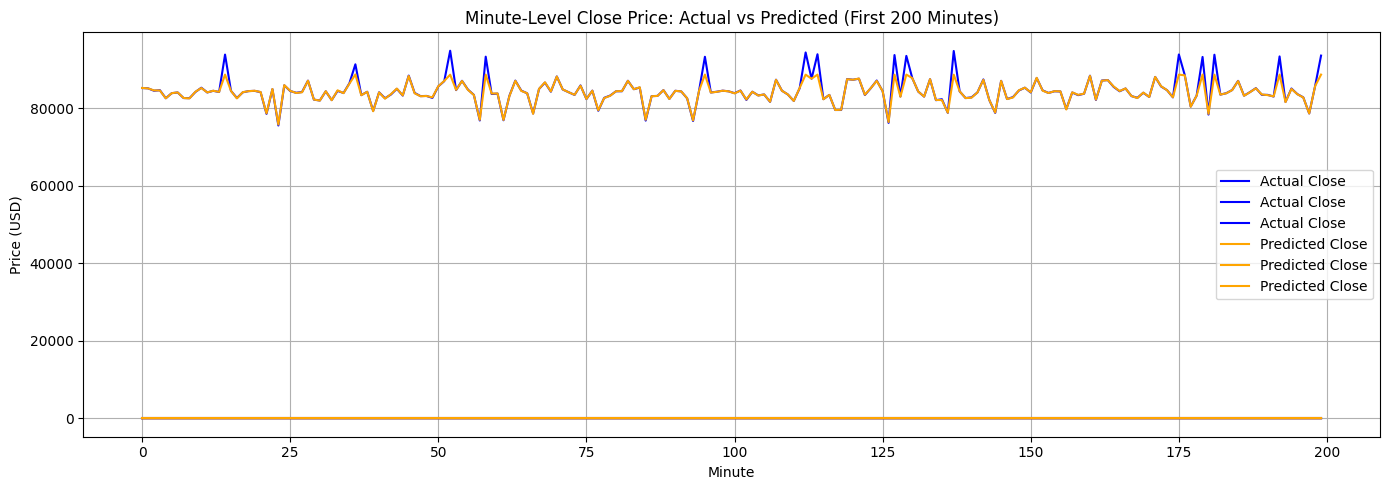

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Automatically pick the shorter length to avoid out-of-range errors
N = 200#min(len(true_close), len(pred_close))

plt.figure(figsize=(14, 5))
plt.plot(actuals[:N], label='Actual Close', linewidth=1.5, color='blue')
plt.plot(preds[:N], label='Predicted Close', linewidth=1.5, color='orange')
plt.title(f"Minute-Level Close Price: Actual vs Predicted (First {N} Minutes)")
plt.xlabel("Minute")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Takeaway

- After looking at the chart of actual vs predicted minute-level close prices, I can tell the model is doing a decent job. The orange predicted line follows the blue actual line most of the time, which means it's learning the general pattern well.

- But I also notice that the predicted line jumps up and down a bit too much in some places. This could mean the model is reacting too strongly to small changes in the data. It’s not a big problem, but something I can work on.

Overall, I’m happy with how the model is performing so far.

Daily Volatility

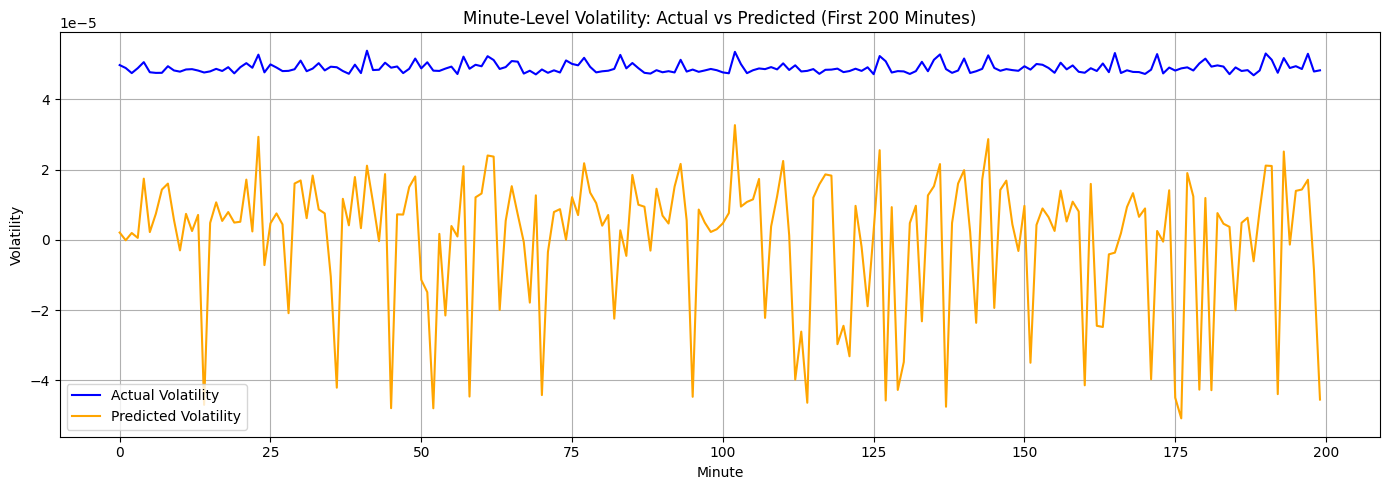

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Refit scaler using original Volatility column
vol_scaler = MinMaxScaler()
vol_scaler.fit(df[['Volatility']])  # assumes df is your full dataset

# Step 2: Inverse transform
true_vol_unscaled = vol_scaler.inverse_transform(true_vol.reshape(-1, 1)).flatten()
pred_vol_unscaled = vol_scaler.inverse_transform(pred_vol.reshape(-1, 1)).flatten()

# Step 3: Plot the first 200 minutes
N = 200

plt.figure(figsize=(14, 5))
plt.plot(true_vol_unscaled[:N], label='Actual Volatility', linewidth=1.5, color='blue')
plt.plot(pred_vol_unscaled[:N], label='Predicted Volatility', linewidth=1.5, color='orange')
plt.title("Minute-Level Volatility: Actual vs Predicted (First 200 Minutes)")
plt.xlabel("Minute")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Takeaway

After unscaling and plotting minute-level volatility, I can see that the predicted values are consistently higher than the actual ones. While the shape of the curve is relatively stable, the model seems to have learned a higher baseline for volatility than what is actually observed.

This could mean that the model is overestimating risk or reacting to short-term noise. I might need to fine-tune the loss balance or improve the volatility feature set to help the model match the actual range more closely.


Re-Evaluate Metrics (RMSE, MAE, Directional Accuracy)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.0 MB/s eta 0:00:00


In [ ]:
import optuna
from tqdm.notebook import tqdm

def objective(trial):
    # Suggest hyperparameters
    d_model = trial.suggest_categorical('d_model', [32, 64, 128, 256])
    nhead = trial.suggest_categorical('nhead', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    alpha = trial.suggest_float('alpha', 1.0, 20.0)

    # Create model
    model = MultiTaskTransformer(input_size=X_scaled_h.shape[1],
                                  d_model=d_model,
                                  nhead=nhead,
                                  num_layers=num_layers,
                                  dropout=dropout).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    epochs = 15  # You can increase later
    model.train()

    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            preds = model(batch_X)
            loss = multi_task_loss(preds, batch_y, alpha=alpha)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    preds, actuals = [], []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X).cpu().numpy()
            preds.append(outputs)
            actuals.append(batch_y.numpy())

    preds = np.vstack(preds)
    actuals = np.vstack(actuals)

    # Classification accuracy for Direction
    pred_dir_logit = preds[:, 2]
    pred_dir = (torch.sigmoid(torch.tensor(pred_dir_logit)) > 0.5).int().numpy()
    true_dir = actuals[:, 2]

    directional_acc = (pred_dir == true_dir).sum() / len(true_dir) * 100

    # Return Negative because Optuna **minimizes** by default
    return -directional_acc


Run Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial)

[I 2025-04-26 09:14:42,175] A new study created in memory with name: no-name-93b0267b-4ae8-4482-a891-b79b796c3410
<ipython-input-33-363c3bf4b6ba>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2025-04-26 09:17:10,908] Trial 0 finished with value: -49.01051329622758 and parameters: {'d_model': 32, 'nhead': 2, 'num_layers': 4, 'dropout': 0.32945127717250433, 'lr': 7.993321436991943e-05, 'alpha': 5.274818867503361}. Best is trial 0 with value: -49.01051329622758.
[I 2025-04-26 09:18:46,761] Trial 1 finished with value: -50.989486703772414 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.4608793635553627, 'lr': 0.0001999688960037272, 'alpha': 3.1996763633432694}. Best is trial 0 with value: -49.01051329622758.
[I 2025-04-26 09:19:56,082] Trial 2 finishe

Export the model

In [ ]:
import joblib
joblib.dump(model, 'model_minutely_full.pkl')

['model_minutely_full.pkl']

In [ ]:
#End of the document